In [594]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

In [595]:
df = pd.read_csv('output.csv')
df["Correctness_Value"] = df["Correctness"]
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df['Question ID'] = pd.Categorical(df['Question ID'],
                                   categories=sorted(df['Question ID'].value_counts().keys()),
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)
df["Given-Expected Answer Pair"] = pd.Categorical(df["Given-Expected Answer Pair"],
                                                 categories=sorted(df["Given-Expected Answer Pair"].value_counts().keys()),
                                                 ordered=True)

In [596]:
from pymer4.models import Lmer

df_lmer = df[["Participant ID", "Prompt Condition", "Question Type", "Correctness_Value"]]
df_lmer = df_lmer.rename(columns={"Participant ID": "Participant_ID", "Prompt Condition": "Prompt_Condition", "Question Type": "Question_Type"})
df_lmer["Prompt_Condition"] = df_lmer["Prompt_Condition"].map({1:"Blank", 2:"Brief", 3:"Full"})
df_lmer["Question_Type"] = df_lmer["Question_Type"].map({1:"Collect/Share", 2:"Data Type", 3:"Data Purpose"})
# print(df_lmer)
model = Lmer("Correctness_Value ~ Prompt_Condition * Question_Type + (Question_Type|Participant_ID)",
             data=df_lmer, family = 'binomial')

print(model.fit())

boundary (singular) fit: see help('isSingular') 

Formula: Correctness_Value~Prompt_Condition*Question_Type+(Question_Type|Participant_ID)

Family: binomial	 Inference: parametric

Number of observations: 4658	 Groups: {'Participant_ID': 115.0}

Log-likelihood: -2809.428 	 AIC: 5648.855

Random effects:

                                     Name    Var    Std
Participant_ID                (Intercept)  0.000  0.000
Participant_ID  Question_TypeData Purpose  0.300  0.547
Participant_ID     Question_TypeData Type  0.214  0.463

                                      IV1                        IV2 Corr
Participant_ID                (Intercept)  Question_TypeData Purpose     
Participant_ID                (Intercept)     Question_TypeData Type     
Participant_ID  Question_TypeData Purpose     Question_TypeData Type    1

Fixed effects:

                                                 Estimate  2.5_ci  97.5_ci  \
(Intercept)                                        -0.626  -0.822   -0.430   


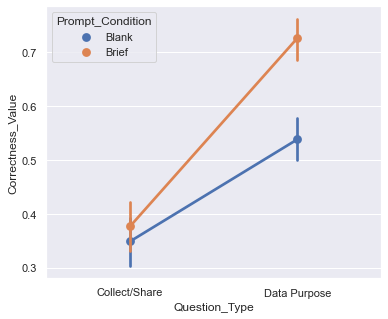

In [597]:
sns.set(rc = {'figure.figsize':(6,5)})
ax = sns.pointplot(x="Question_Type", y="Correctness_Value", hue="Prompt_Condition", data=df_lmer[df_lmer["Prompt_Condition"].isin(["Blank", "Brief"]) & df_lmer["Question_Type"].isin(["Collect/Share", "Data Purpose"])])
plt.savefig("brief_purpose_interaction_plot.pdf", bbox_inches='tight')
plt.savefig("brief_purpose_interaction_plot.png", dpi=300, bbox_inches='tight')

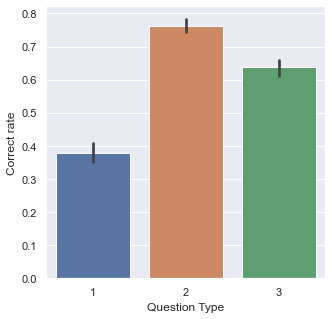

In [598]:
sns.set(rc = {'figure.figsize':(5,5)})
g = sns.barplot(x= "Question Type", y= "Correctness_Value", data=df)
plt.ylabel("Correct rate")
plt.savefig("question_type_correct_rate.pdf", bbox_inches='tight')
plt.savefig("question_type_correct_rate.png", dpi=300, bbox_inches='tight')

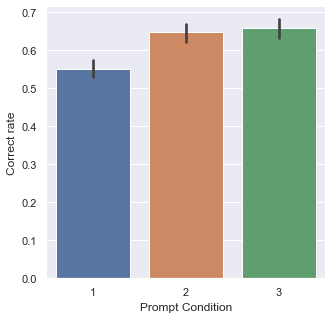

In [599]:
sns.set(rc = {'figure.figsize':(5,5)})
g = sns.barplot(x= "Prompt Condition", y= "Correctness_Value", data=df)
plt.ylabel("Correct rate")
plt.savefig("prompt_condition_correct_rate.pdf", bbox_inches='tight')
plt.savefig("prompt_condition_correct_rate.png", dpi=300, bbox_inches='tight')

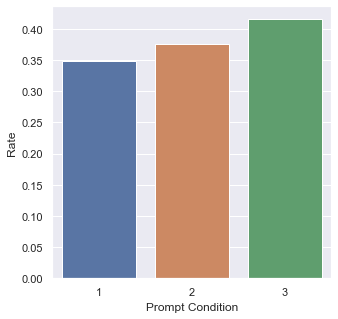

In [600]:
type1 = df[df["Question Type"] == 1]
types = type1.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


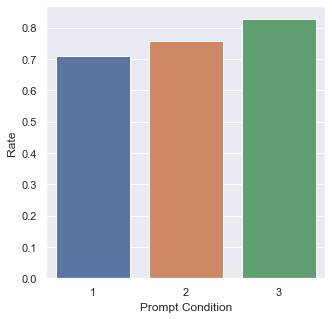

In [601]:
type2 = df[df["Question Type"] == 2]
types = type2.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


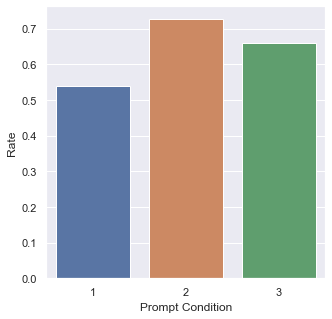

In [602]:
type3 = df[df["Question Type"] == 3]
types = type3.groupby("Prompt Condition")["Correctness"].value_counts(normalize=True)
types = types.drop(labels=['Incorrect'], level = 1)
df1 = pd.DataFrame(types)
df1 = df1.rename(columns={"Correctness" : "Rate"})
g = sns.barplot(x= "Prompt Condition", y= "Rate", data=df1.reset_index())


-1    0.56068
1     0.43932
0     0.00000
Name: Order Difference, dtype: float64
-1    0.56869
1     0.43131
0     0.00000
Name: Order Difference, dtype: float64


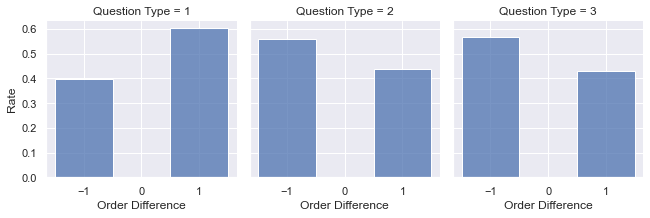

In [603]:
df_incorrect = df[df["Order Difference"] != 0]
print(df_incorrect[df_incorrect["Question Type"] == 2]["Order Difference"].value_counts(normalize=True))
print(df_incorrect[df_incorrect["Question Type"] == 3]["Order Difference"].value_counts(normalize=True))
g = sns.FacetGrid(df_incorrect, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Order Difference", stat="probability")
graph.set_xlabels("Order Difference")
graph.set_ylabels("Rate")

In [604]:
df1 = pd.read_csv('output.csv')
df1["Prompt Condition"] = df1["Prompt Condition"].map({1:"Blank", 2:"Brief", 3:"Full"})

In [605]:
def plot_correct_rate_per_condition(df1, target_question_category):
    type1 = df1[df1["Question Type"] == 1]
    type1 = type1[type1["Question Category"] == target_question_category]
    print(type1.apply(lambda row:row["Question Name"] + row["Prompt Condition"], axis=1).value_counts())
    type1["Question Name"] = type1.apply(lambda row: row["Question Name"].split("Please select")[0], axis=1)
    sns.set(rc = {'figure.figsize':(5,5)})
    g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type1, orient="h")
    prefix = target_question_category.replace(" ", "_")
    plt.savefig(f"{prefix}_question_correct_rate_per_condition.png", dpi=300, bbox_inches='tight')

In [606]:
def print_count_per_question_condition(df1, target_question_type):
    type1 = df1[df1["Question Type"] == target_question_type]
    type1_dict = type1.apply(lambda row:row["Question Name"] + row["Prompt Condition"], axis=1).value_counts().to_dict()
    print(len(type1_dict.keys()))
    print(type1_dict)

In [607]:
print_count_per_question_condition(df1, 1)

63
{"Our app's user explicitly initiates an action that sends their full name to a third party server. Please select how you would report your app's data practices regarding the user's full name.Blank": 23, "Our app accesses GPS location and sends it to another app directly on the device. The data never leaves the device.(This is feasible because an app can use an Intent to perform some basic interactions with other apps, including sending data) Please select how you would report your app's data practices regarding GPS location.Blank": 22, "Our app accesses the user’s GPS location and sends it to government agencies in response to a legal request. Please select how you would report our app's data practices regarding the user's GPS location.Blank": 22, "Our app requests for the user's full name and only sends the pseudonymized name to our server. (A pseudonymized name does not allow the individual to be directly identified, but it can be re-associated with the user if additional informa

In [608]:
print_count_per_question_condition(df1, 2)

231
{"the user's personal phone numberBlank": 10, 'the latency of the appFull': 9, "information related to the user's  interaction duration with their contactsBlank": 9, "attendees of the user's calendar eventsBlank": 9, 'the content of instant messages/chats sent or received by the userBlank': 9, "information about the user's contact recencyBrief": 9, "the user's veteran statusBlank": 9, "information related to the user's contact frequencyBlank": 9, "the user's purchase historyBlank": 9, "the user's salaryBlank": 9, "the user's website browsing historyBrief": 9, "the user's credit scoreBlank": 9, "the user's account nameBrief": 9, "in a cloud storage app that you have designed, the user's filesFull": 9, "the user's photosBlank": 9, "the user's sexual orientationFull": 9, "the user's selection from in-app dialog options.Brief": 9, "the user's reported exercise/physical activityBlank": 9, "the user's account IDBlank": 9, "coordinates of the user's taps in the appFull": 9, "the user's de

In [609]:
print_count_per_question_condition(df1, 3)

45
{"Our app utilizes the user device's MAC address in order to isolate suspicious login attempts from new devices.Blank": 42, "Our map app utilizes the user's location data to get real-time traffic updatesBlank": 42, 'Our app collects and utilizes user email addresses in order to send announcements about new app features.Blank': 42, 'Our app collects user contact information to inform users about security patches.Blank': 42, "Our weather app utilizes the user's location data to deliver information related to the air quality in their current area.Blank": 42, "Our app shares the user's information with advertising partners to select ads of interest to each user.Blank": 42, 'Our app collects information required to discern how many users utilized the real-time weather forecasting feature of the app.Blank': 42, "Our shopping app collects data related to the user's previous purchases to suggest new products on our site that might appeal to them.Blank": 42, 'Our app collects data in order t

Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Blank    21
Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Full     18
Our app accesses GPS location and sends it to our server. Please select how you would report our app's data practices regarding GPS location.Brief    17
dtype: int64


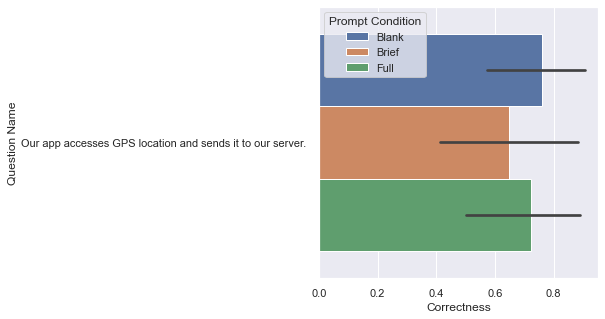

In [610]:
plot_correct_rate_per_condition(df1, "collect basic")

Our app requests for the user's full name and only sends the pseudonymized name to our server. (A pseudonymized name does not allow the individual to be directly identified, but it can be re-associated with the user if additional information is provided) Please select how you would report our app's data practices regarding the user's full name.Blank    22
Our app sends the user's GPS location to our server to search for nearby places but does not store the GPS location after serving the request. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                                                                                 21
Our app accesses GPS location and sends it to our server via libraries and/or SDKs included in our app. Please select how you would report our app's data practices regarding GPS location.Blank                                                                                            

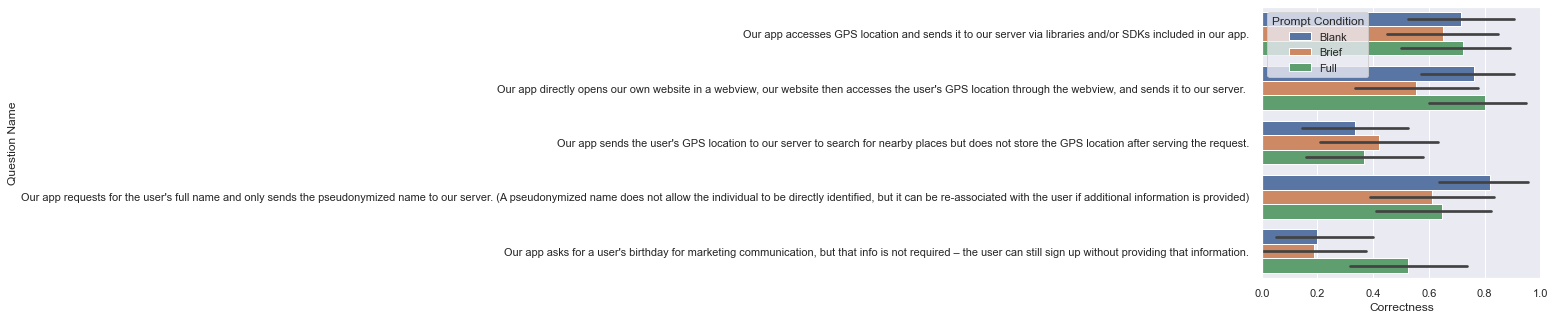

In [611]:
plot_correct_rate_per_condition(df1, "collect special")

Our app allows users to navigate the open web via a webview. When the user opens google.com, it accesses the user's GPS location and sends the GPS location to Google's server.  Please select how you would report our app's data practices regarding GPS location.Blank    21
Our app encrypts the user’s message before it is sent to another user, where it is decrypted. Please select how you would report our app's data practices regarding the user's messages.Blank                                                                                21
Our app accesses and processes the user's GPS location directly on the user’s device. The data never leaves the device. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                  20
Our app allows users to navigate the open web via a webview. When the user opens google.com, it accesses the user's GPS location and sends the GPS location to Google's server.  Please 

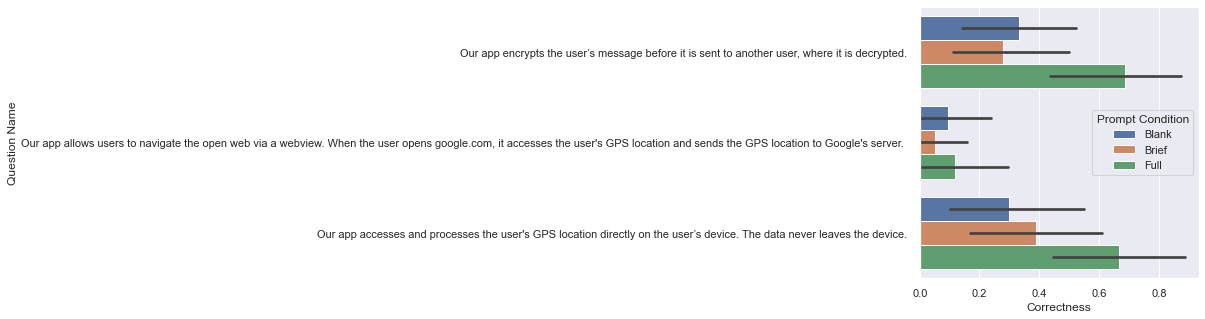

In [612]:
plot_correct_rate_per_condition(df1, "collect exempt")

Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Blank    21
Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Brief    20
Our app accesses GPS location and sends it to a third party server. Please select how you would report our app's data practices regarding GPS location.Full     18
dtype: int64


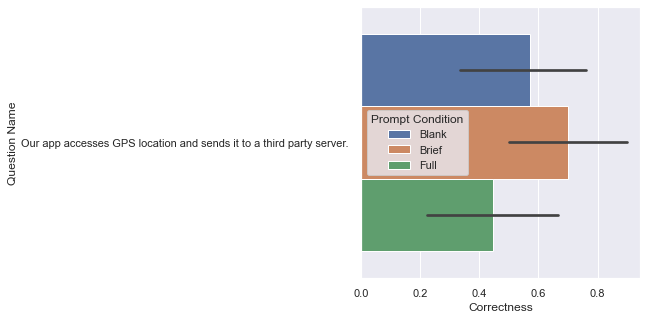

In [613]:
plot_correct_rate_per_condition(df1, "share basic")

Our app accesses GPS location and sends it to another app directly on the device. The data never leaves the device.(This is feasible because an app can use an Intent to perform some basic interactions with other apps, including sending data) Please select how you would report your app's data practices regarding GPS location.Blank    22
Our app directly opens our own website in a webview, our website accesses the GPS location through the webview, and sends it to a third party server.  Please select how you would report your app's data practices regarding GPS location.Blank                                                                                               22
Our app accesses GPS location and sends it directly to a third party server via libraries and/or SDKs included in our app. Please select how you would report our app's data practices regarding GPS location.Full                                                                                                                  

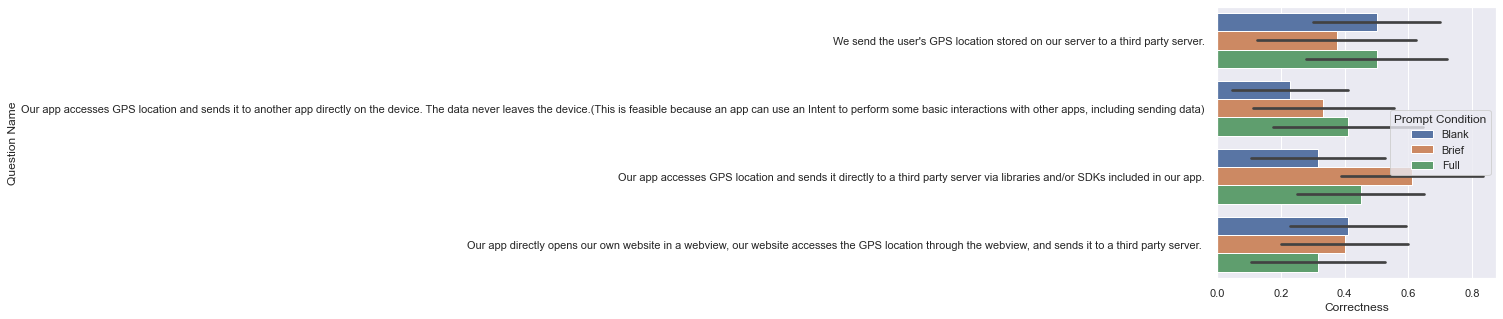

In [614]:
plot_correct_rate_per_condition(df1, "share special")

Our app's user explicitly initiates an action that sends their full name to a third party server. Please select how you would report your app's data practices regarding the user's full name.Blank                                                                                    23
Our app accesses the user’s GPS location and sends it to government agencies in response to a legal request. Please select how you would report our app's data practices regarding the user's GPS location.Blank                                                                       22
Our app sends the user's full name to a third party server after obtaining the user's consent to it. Please select how you would report your app's data practices regarding the user's full name.Blank                                                                                 21
Our app allows users to navigate the open web via a webview. When the user opens google.com, it accesses the user's GPS location and sends the GPS locatio

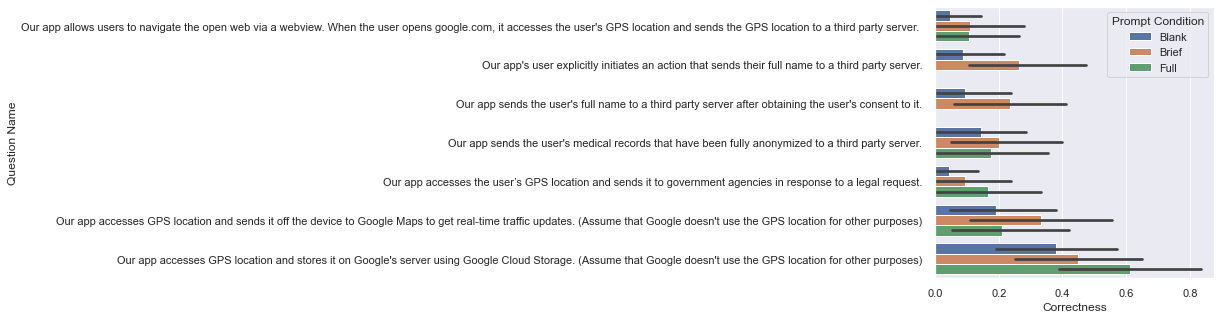

In [615]:
plot_correct_rate_per_condition(df1, "share exempt")

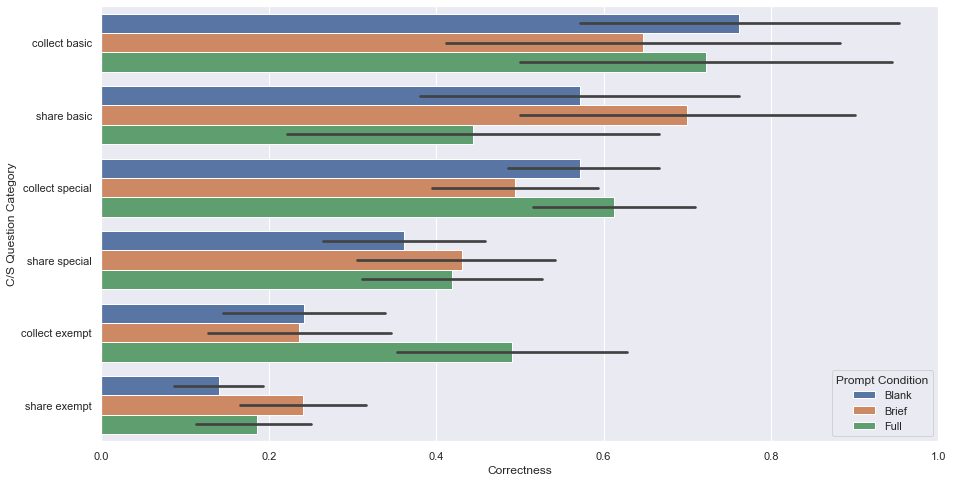

In [616]:
type1 = df1[df1["Question Type"] == 1]
type1 = type1.rename(columns={"Correctness Value" : "Correct Rate", "Question Category": "C/S Question Category"})
sns.set(rc = {'figure.figsize':(15,8)})
g = sns.barplot(y= "C/S Question Category", x= "Correctness", hue = "Prompt Condition", data=type1, orient="h", order=["collect basic", "share basic", "collect special", "share special", "collect exempt", "share exempt"])
plt.savefig("collect_share_question_category_correct_rate.pdf", bbox_inches='tight')
plt.savefig("collect_share_question_category_correct_rate.png", dpi=300, bbox_inches='tight')

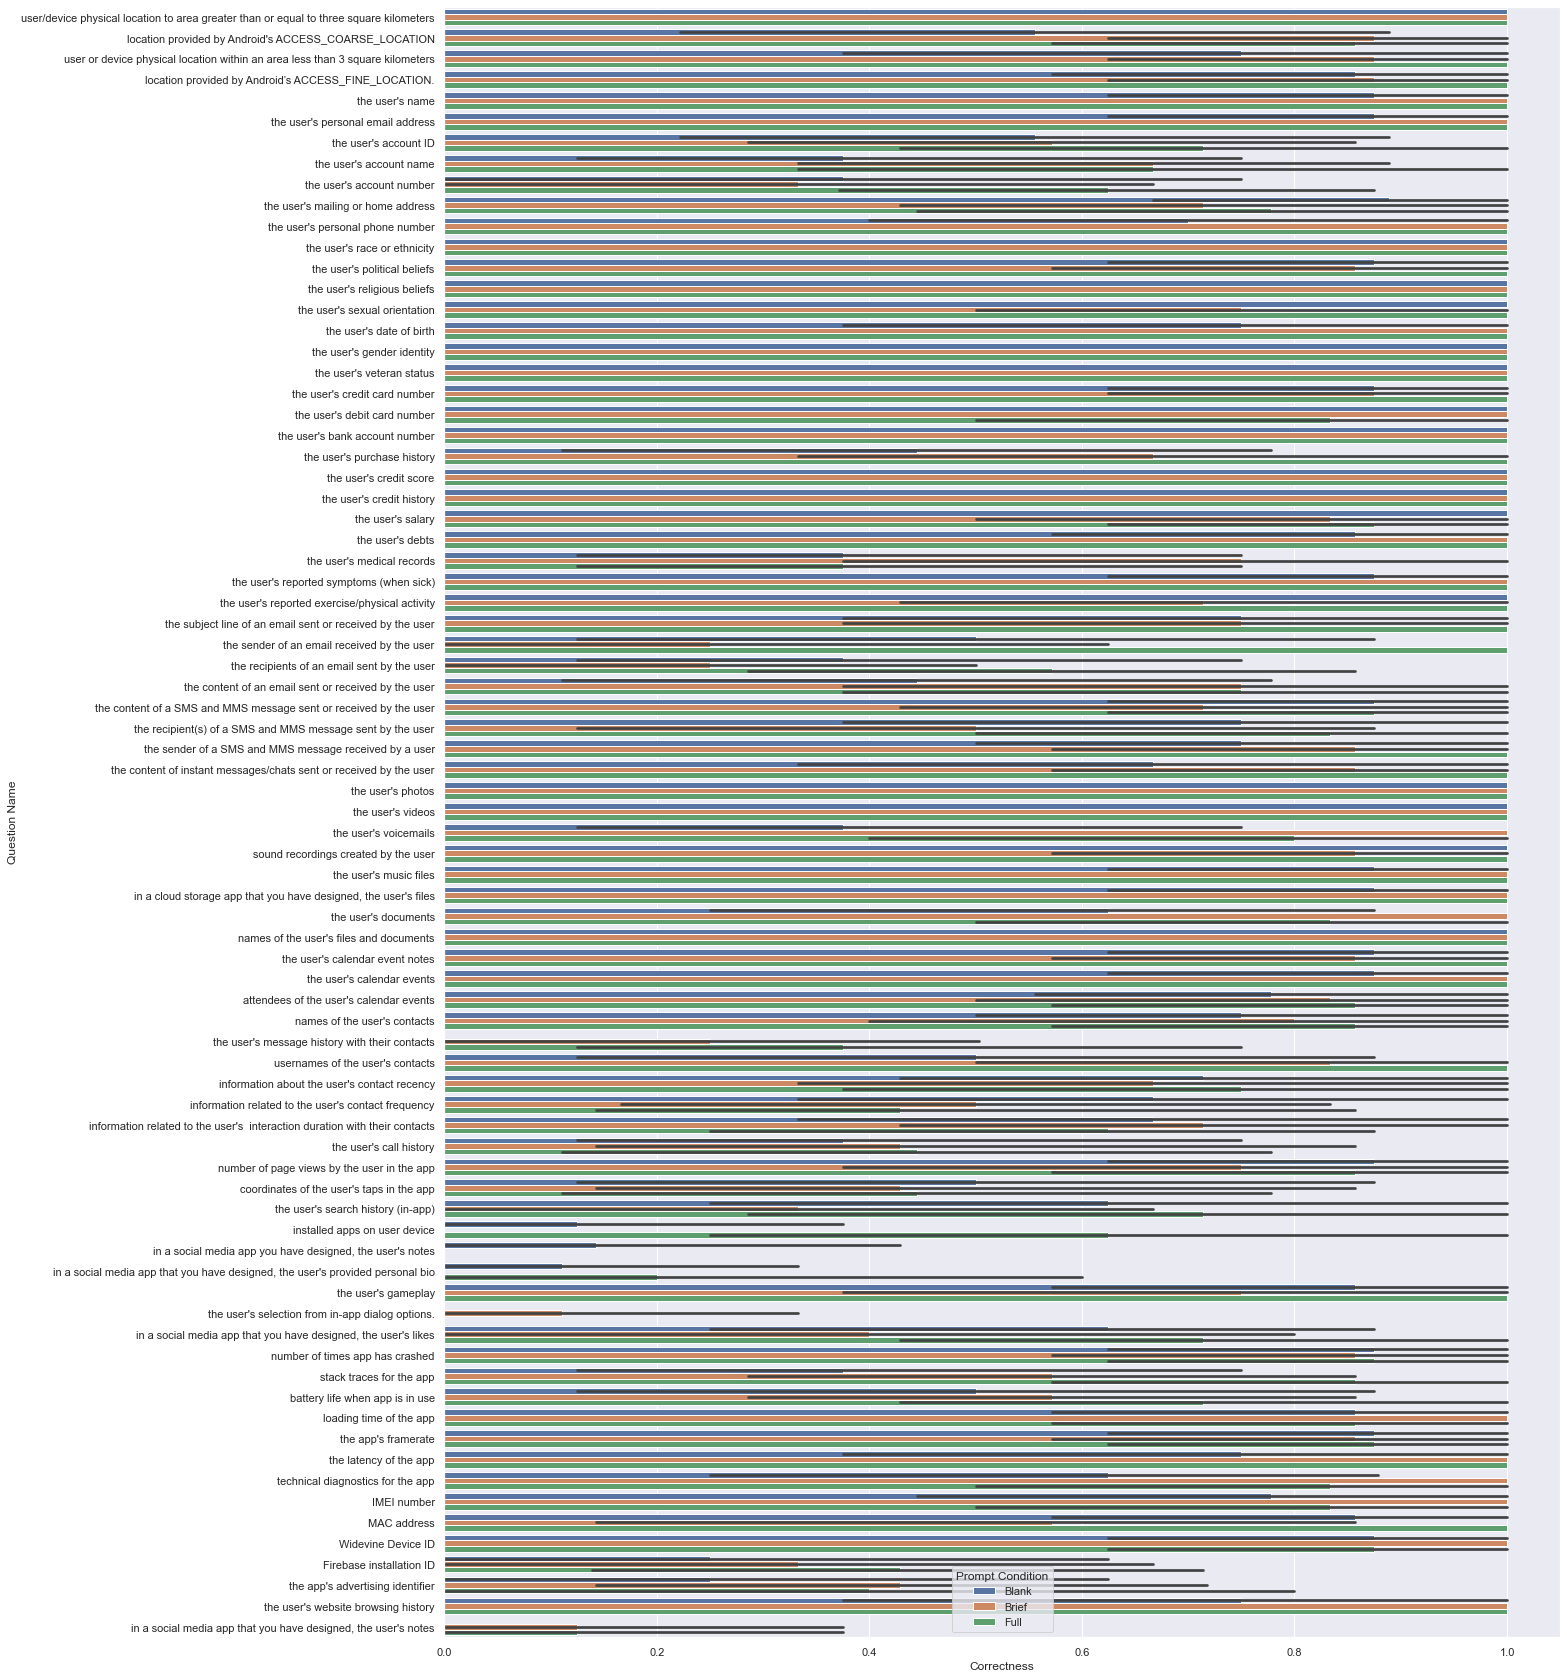

In [617]:
type2 = df1[df1["Question Type"] == 2]
sns.set(rc = {'figure.figsize':(20,30)})
g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type2, orient='h')

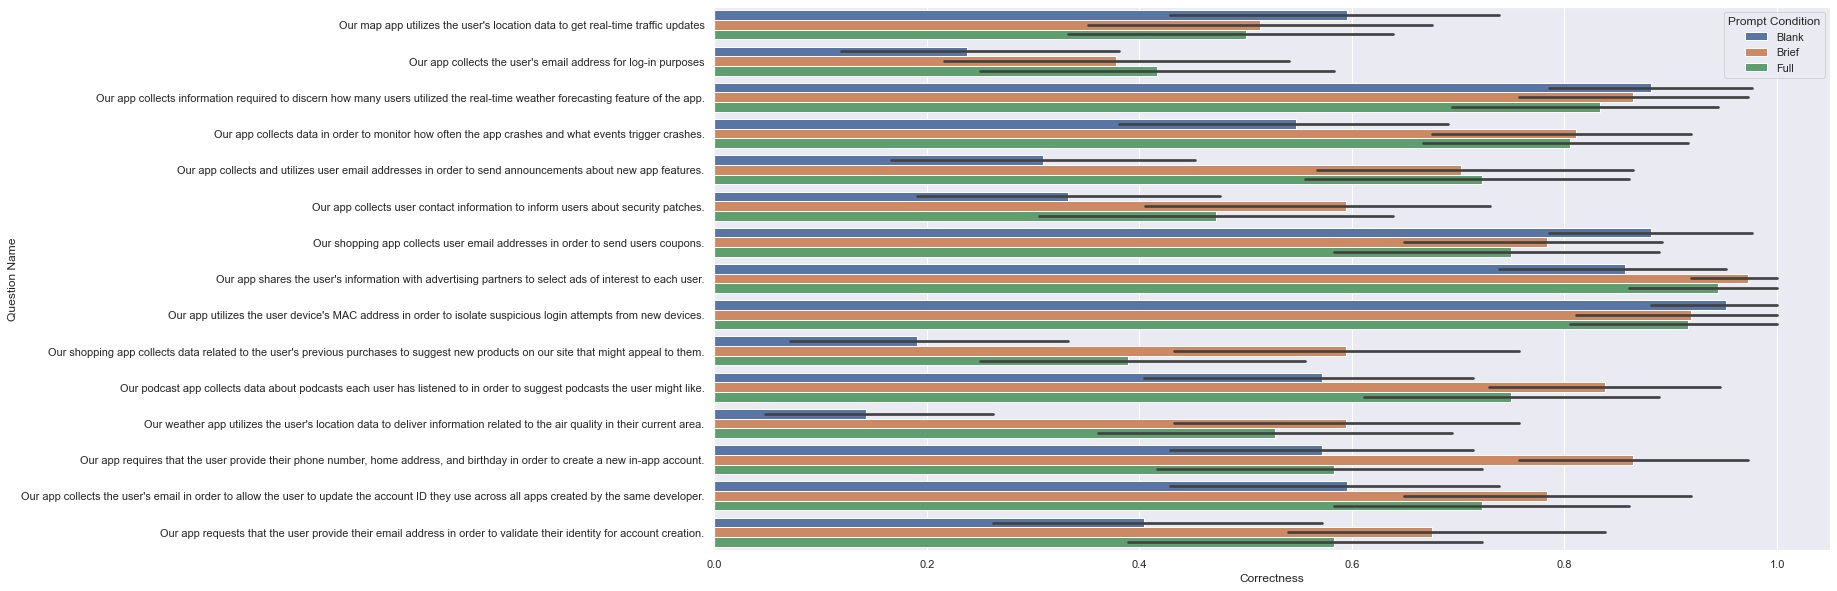

In [618]:
type3 = df1[df1["Question Type"] == 3]
sns.set(rc = {'figure.figsize':(20,10)})
g = sns.barplot(y= "Question Name", x= "Correctness", hue = "Prompt Condition", data=type3, orient="h")

In [619]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)


Text(0.5, 0.98, 'Given-Expected Answer Pair')

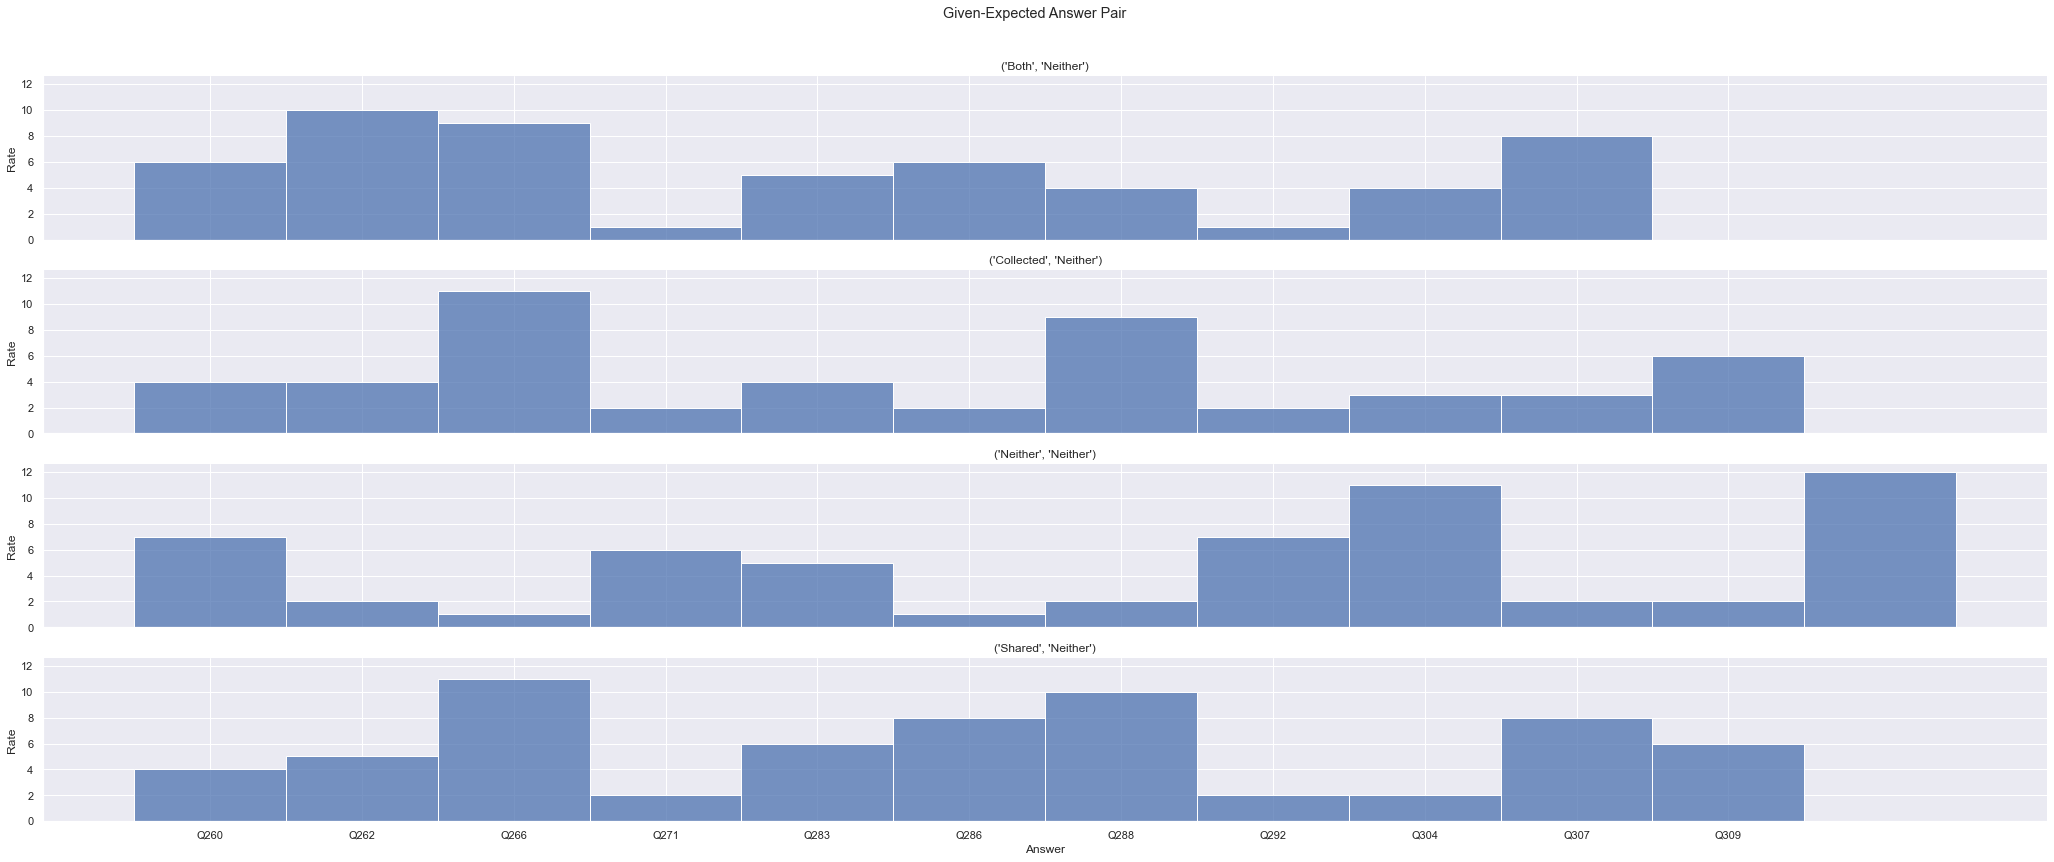

In [620]:
g = sns.FacetGrid(df[df["Correct Answer"] == "Neither"], col = "Given-Expected Answer Pair", col_wrap=1, aspect=9.5,
                 col_order=sorted(df[df["Correct Answer"] == "Neither"]["Given-Expected Answer Pair"].value_counts().keys()))
graph = g.map_dataframe(sns.histplot, x = "Question ID", stat="count")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a title for the entire plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Given-Expected Answer Pair")

           Collected    Shared      Both   Neither
Collected   0.393372  0.279539  0.244957  0.082133
Shared      0.157895  0.315789  0.210526  0.315789
Both        0.108225  0.415584  0.467532  0.008658
Neither     0.221239  0.283186  0.238938  0.256637


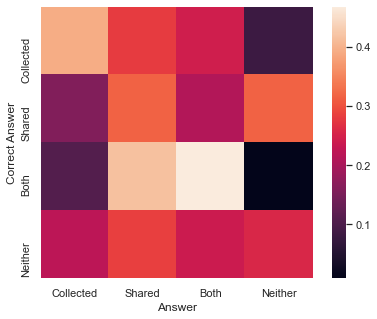

In [621]:
t1 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t1 = t1[t1["Question Type"] == 1]
t1 = t1.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t1.loc[:, "Correct Answer"]
actualAnswers = t1.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["Collected", "Shared", "Both", "Neither"]
type1 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type1.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type1.at[rowNames[i], rowNames[j]] = 0
type1 = type1.astype(float)
print(type1)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type1, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("collect_sharing_heatmap.pdf", bbox_inches='tight')
plt.savefig("collect_sharing_heatmap.png", dpi=300, bbox_inches='tight')

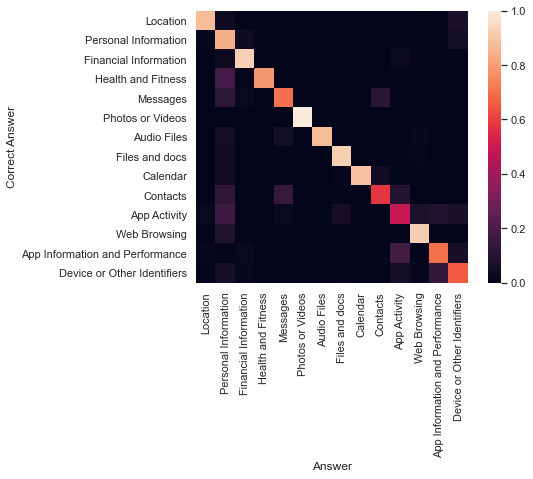

In [622]:
t2 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t2 = t2[t2["Question Type"] == 2]
t2 = t2.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t2.loc[:, "Correct Answer"]
actualAnswers = t2.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["Location", "Personal Information", "Financial Information", "Health and Fitness", "Messages", "Photos or Videos", "Audio Files", "Files and docs", "Calendar", "Contacts", "App Activity", "Web Browsing", "App Information and Performance", "Device or Other Identifiers"]
type2 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type2.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type2.at[rowNames[i], rowNames[j]] = 0
type2 = type2.astype(float)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type2, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("data_type_heatmap.pdf", bbox_inches='tight')
plt.savefig("data_type_heatmap.png", dpi=300, bbox_inches='tight')

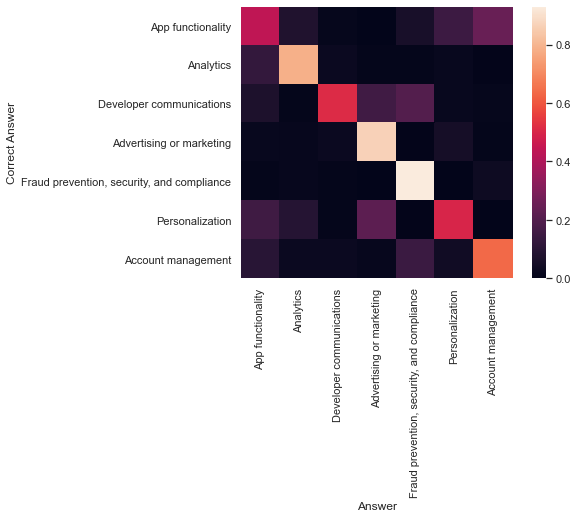

In [623]:
t3 = pd.read_csv('output.csv', usecols = [4, 5, 6])
t3 = t3[t3["Question Type"] == 3]
t3 = t3.drop("Question Type", 1)
correctTotals = dict()
correctAnswers = t3.loc[:, "Correct Answer"]
actualAnswers = t3.loc[:, "Answer"]
answerPairs = dict()
for (i,j) in zip(correctAnswers, actualAnswers):
    correctTotals[i]= correctTotals.get(i, 0) + 1
    answerPairs[(i, j)] = answerPairs.get((i, j), 0) + 1
#create ratios for actual/correct answers
for (correct, actual) in answerPairs:
    answerPairs[(correct, actual)] = answerPairs[(correct, actual)] / correctTotals[correct]
rowNames = ["App functionality", "Analytics", "Developer communications", "Advertising or marketing", "Fraud prevention, security, and compliance", "Personalization", "Account management"]
type3 = pd.DataFrame(columns=rowNames, index=rowNames)
for i in range(len(rowNames)):
    for j in range(len(rowNames)):
        if (rowNames[i], rowNames[j]) in answerPairs:
            type3.at[rowNames[i], rowNames[j]] = answerPairs[(rowNames[i], rowNames[j])]
        else:
            type3.at[rowNames[i], rowNames[j]] = 0
type3 = type3.astype(float)
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.heatmap(type3, square=True)
g.set(xlabel= "Answer", ylabel = "Correct Answer")
plt.savefig("data_purpose_heatmap.pdf", bbox_inches='tight')
plt.savefig("data_purpose_heatmap.png", dpi=300, bbox_inches='tight')